# Evaluating HRRR performance in wind gust potential

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial import distance

### Loading data

These datasets are not at the same time, so only general trends can be evaluated. 

Future - Find nearest METAR station to a HRRR prediction in order to evaluate specific predictions. 

In [2]:
Met_20170701 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')
Hrrr = Dataset(  # HRRR
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/extract2Da.esrl_hrrr.201718201001300.nc')

Removing any wind gusts > 10,000 m/s, should only be NAN fill values (3.4028235e+38). 

In [3]:
met_lon = Met_20170701.variables['longitude']
met_lat = Met_20170701.variables['latitude']
met_gust = Met_20170701.variables['windGust']
met_temp = Met_20170701.variables['temperature']
met_windspeed = Met_20170701.variables['windSpeed']
met_press = Met_20170701.variables['seaLevelPress']

cell = []
for g, lon, lat, t, ws, p in zip(met_gust, met_lon, met_lat, 
                                     met_temp, met_windspeed, met_press):
    cell.append((g, lon, lat, t, ws, p))

met_arr = np.asarray(cell)
np.nan_to_num(met_arr, False, 0)
met_arr.shape

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(7952, 6)

In [8]:
hrrr_gust = Hrrr.variables['GUST_P0_L1_GLC0']
hrrr_lat = Hrrr.variables['gridlat_0']
hrrr_lon = Hrrr.variables['gridlon_0']

hrrr_gust_flat = np.concatenate(hrrr_gust)
hrrr_lat_flat = np.concatenate(hrrr_lat)
hrrr_lon_flat = np.concatenate(hrrr_lon)

cell = []
for g, lon, lat in zip(hrrr_gust_flat, hrrr_lon_flat, hrrr_lat_flat):
    cell.append((g, lon, lat))

hrrr_arr = np.asarray(cell)
np.nan_to_num(hrrr_arr, False, 0)
hrrr_arr.shape

(1905141, 3)

Looking for interesting features of the aggregate predictions. 

(0.0, 1000.0)

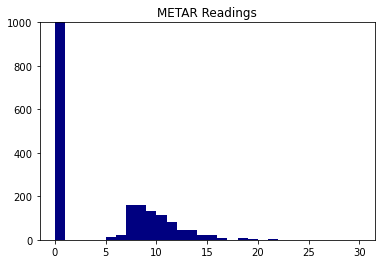

In [9]:
hist_metar = plt.hist(met_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("METAR Readings")
plt.ylim(0,1000)

(0.0, 1000000.0)

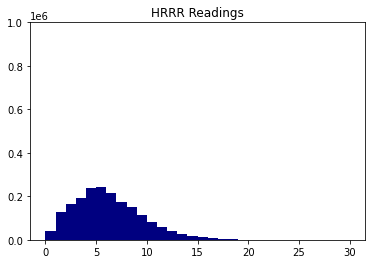

In [12]:
hist_hrrr = plt.hist(hrrr_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("HRRR Readings")
plt.ylim(0,1000000)

### Testing the process of building the closest HRRR to METAR table. 

In [19]:
(round(met_arr[1, 1], 3), round(met_arr[1, 2], 3))

(4.92, 53.24)

Measures dist as points of latitude/longitude (I believe), not kilometers. Will need some sort of conversion to find one within 3km. 

In [24]:
lookup_dict = {}
count = 0
for i in range(10,11):
    for j in range(len(hrrr_arr)):
        dist = distance.euclidean((met_arr[i, 1], met_arr[i, 2]), (hrrr_arr[j, 1], hrrr_arr[j, 2]))
        if (dist < 5):
            count += 1
            lookup_dict[count] = {
                "metar": (met_arr[i, 1], met_arr[i, 2]),
                "hrrr": (hrrr_arr[j, 1], hrrr_arr[j, 2]),
                "distance": round(dist, 3)
            }

lookup_dict

{1: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.694145, 44.13694),
  'distance': 5.0},
 2: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.65813, 44.14419),
  'distance': 4.997},
 3: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.6221, 44.151432),
  'distance': 4.995},
 4: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.586075, 44.158665),
  'distance': 4.993},
 5: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.55003, 44.165886),
  'distance': 4.991},
 6: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.513985, 44.173096),
  'distance': 4.989},
 7: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.47793, 44.180294),
  'distance': 4.988},
 8: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.441864, 44.187485),
  'distance': 4.987},
 9: {'metar': (-123.30000305175781, 49.099998474121094),
  'hrrr': (-122.40579, 44.194668

In [42]:
some_pt1 = [(10.76,2.9),(3.24,4.28),(7.98,1.98),(3.21,9.87)]
some_pt2 = [(11.87,6.87), (67.87,8.88), (44.44, 6.78), (9.81, 1.09), (6.91, 0.56), (8.76, 8.97), (8.21, 71.66)]

empty_dict = {}
count = 0
for i in range(len(some_pt1)):
    for j in range(len(some_pt2)):
        dist = distance.euclidean(some_pt1[i],some_pt2[j])
        if (dist < 5):
            count += 1
            empty_dict[count] = {
                "metar": some_pt1[i],
                "hrrr": some_pt2[j],
                "distance": round(dist, 3)
            }

empty_dict

{1: {'metar': (10.76, 2.9), 'hrrr': (11.87, 6.87), 'distance': 4.122},
 2: {'metar': (10.76, 2.9), 'hrrr': (9.81, 1.09), 'distance': 2.044},
 3: {'metar': (10.76, 2.9), 'hrrr': (6.91, 0.56), 'distance': 4.505},
 4: {'metar': (7.98, 1.98), 'hrrr': (9.81, 1.09), 'distance': 2.035},
 5: {'metar': (7.98, 1.98), 'hrrr': (6.91, 0.56), 'distance': 1.778}}

### Closest HRRR to METAR. Too slow, runs for a long time, stopped after running for 15 minutes. 

In [17]:
lookup_dict = {}
count = 0
for i in range(len(met_arr)):
    for j in range(len(hrrr_arr)):
        dist = distance.euclidean((met_arr[i, 1], met_arr[i, 2]), (hrrr_arr[j, 1], hrrr_arr[j, 2]))
        if (dist < 5):
            count += 1
            empty_dict[count] = {
                "metar": (met_arr[i, 1], met_arr[i, 2]),
                "hrrr": (hrrr_arr[j, 1], hrrr_arr[j, 2]),
                "distance": round(dist, 3)
            }

lookup_dict

{}